In [1]:
# %matplotlib widget
# %matplotlib inline
%matplotlib qt5

In [53]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
plt.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
# expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_241025')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_241025


In [6]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_path = os.path.join(os.getcwd(), config_file)

# config_file = 'config.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)

print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
import yaml
print('Using config file', config_path)
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


In [11]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
# im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
im = InstrumentManager(ns_address='10.108.30.75') # Spilker Vibranium
# print(im)
print(im.keys())

dict_keys(['Pyro.NameServer', 'Qick_QRAM'])


In [12]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [10]:
lo1 = im[yaml_cfg.aliases.readout_LO]
# lo1 = SignalCore(name="SignalCore", address='10003494')
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# print(lo1.get_device_status().pll_status.crs_pll_ld)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# # lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# # lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo_freq = 4385.5e6
# lo_power = 14
# lo1.set_frequency(lo_freq) # Set LO frequency
# print(f'set lo freq to {lo_freq*1e-6} MHz')
# lo1.set_power(lo_power) # Set LO power
# print(f'set lo power to {lo_power} dBm')

KeyError: 'SC_20A1'

# Single qubit RB

In [11]:
qubit_i = 2
# qubits = [2, 1]
# qubit_i = qubits[0]

step 20
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 501.288233333334, -229.94910723], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.35], 'readout_length': [8.0, 10.0, 7.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4110.428247950795, 4105.038816552946, 4110.198576889643, 4109.933722963169, 3442.8436398119666, 3448.2234633901926, 3447.122665677232, 3446.8985639748066, 4762.066958508102, 4761.098043820929, 4762.201572322125, 4761.678033261405, 4381.167436176662, 4380.365504198304, 4381.142621732222, 4381.679544300405], 'f_ef': [3884.3737933985267, 0.0, 0.0, 0.0, 0.0, 3347.761789059698, 0.0, 0.0, 4571.9056482340775, 4570.482481434396, 4572.387578885567, 0.0, 4211.706921103304, 4207.262930371132, 0.0, 4209.981140744554], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999]

  0%|          | 0/2 [00:00<?, ?it/s]

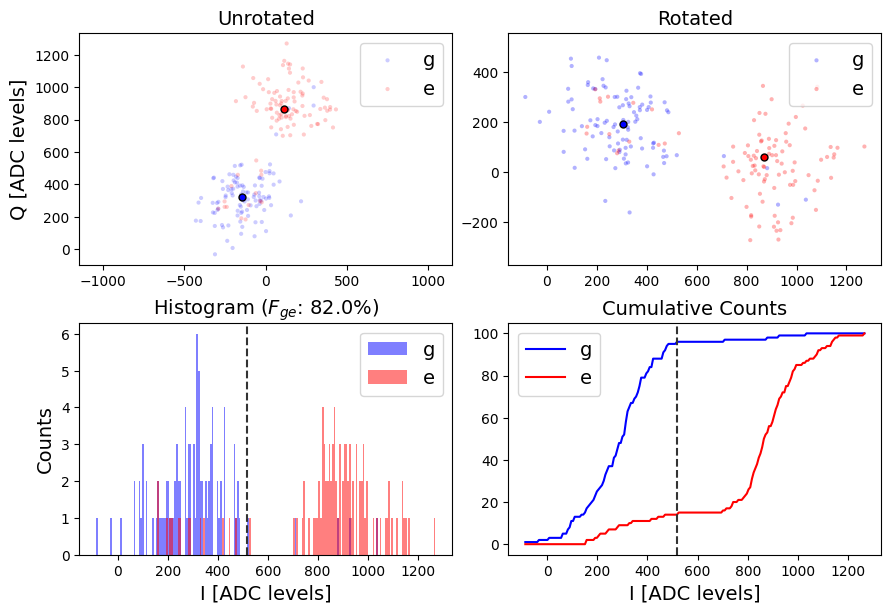

thresholds=[0, 0, 517.9565194773803, 0],
angles=[0, 0, -79.53534652695703, 0],
ge_avgs=[[0, 0, 0, 0], [0, 0, 0, 0], [-128.4941906976744, 333.5667162790698, 103.54448837209306, 820.5909116279072], [0, 0, 0, 0]] ,
counts_calib=[[95.0, 5.0], [14.0, 86.0]]


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
rbprog = meas.SimultaneousRBExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'

# max_gates = 225

max_gates = 100
# expts = 30
expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)


rbprog.cfg.expt = dict(
    # start=1, # rb depth start
    start=34, # rb depth start
    step=step, # step rb depth
    # step=5, # step rb depth
    # expts=expts, # number steps
    expts=1, # number steps
    reps=5000, # number averages per unique sequence
    variations=3, # number different sequences per depth
    gate_char=None, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=[qubit_i], # the qubits to perform simultaneous RB on (if eg-gf, q should be qA != 1)
    # qubits=qubits,
    # qDrive=qubits[0],
    # singleshot_reps=20000, # reps per state for singleshot calibration
    singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    # thresholds=[0, 613.9114184246247, 507.47891189954305, 0],
    # angles=[0, -101.54512016437148, 72.02480620589141, 0],
    # ge_avgs=[array([0., 0., 0., 0.]), [-101.85060937209302, 466.51286116279067, -154.72153951162792, 742.5887439767441], [21.863250678241997, -256.37994772110693, 120.73579574064026, -794.2915984536081], array([0., 0., 0., 0.])],
    # counts_calib=[[16238, 3110, 527, 125], [3374, 16034, 95, 497], [1968, 395, 14344, 3293], [494, 2404, 2838, 14264]]
)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.analyze(fit=True)
rbprog.display(fit=True, qubit=[qubit_i])

In [ ]:
p_irb = 0.913
p_rb = 0.949  
print(100*meas.fitting.rb_error(p_rb, 2),'% average error')
print(100*(1-meas.fitting.rb_gate_fidelity(p_rb, p_irb, 2)), '% gate error')

In [ ]:
qDrive = qubits[0]
setup_ZZ = 0

In [ ]:
rbprog.save_data()

### EF RB

In [22]:
qubit_i = 3

ZZ_qubit = 0 # for initialization
# ZZ_qubit = None

test_qZZ = ZZ_qubit

step 3
running 1 loops


  0%|          | 0/3 [00:00<?, ?it/s]

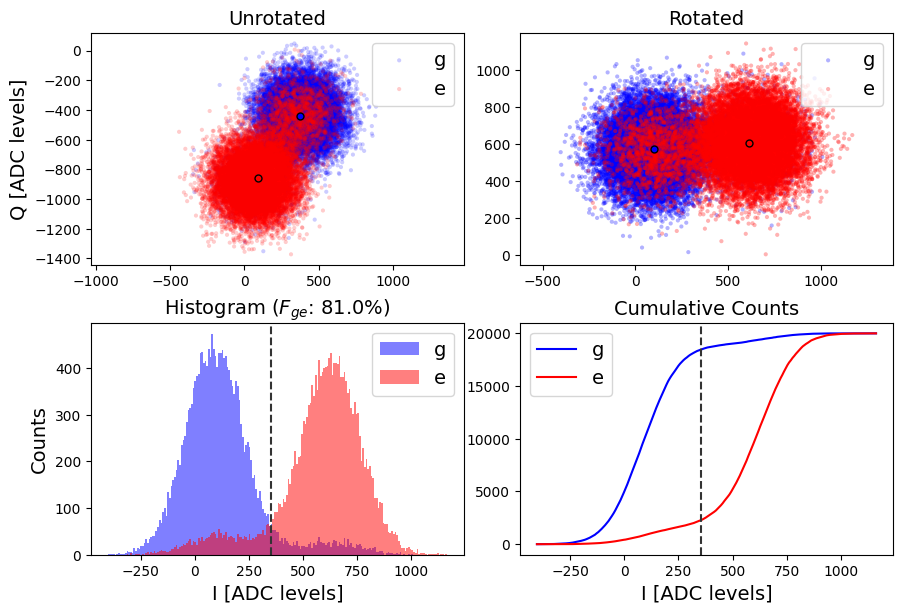

thresholds=[0, 0, 0, 351.71596562623955],
angles=[0, 0, 0, 129.29233678903194],
ge_avgs=[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [365.887408220293, -457.7089064568638, 100.91732004883343, -833.6900771296799]] ,
thresholds=[0, 0, 0, 351.71596562623955],
angles=[0, 0, 0, 129.29233678903194],
ge_avgs=[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [365.887408220293, -457.7089064568638, 100.91732004883343, -833.6900771296799]],
counts_calib=[[18389.0, 1611.0], [2198.0, 17802.0], [1684.0, 18316.0]]


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Qubit (3) f


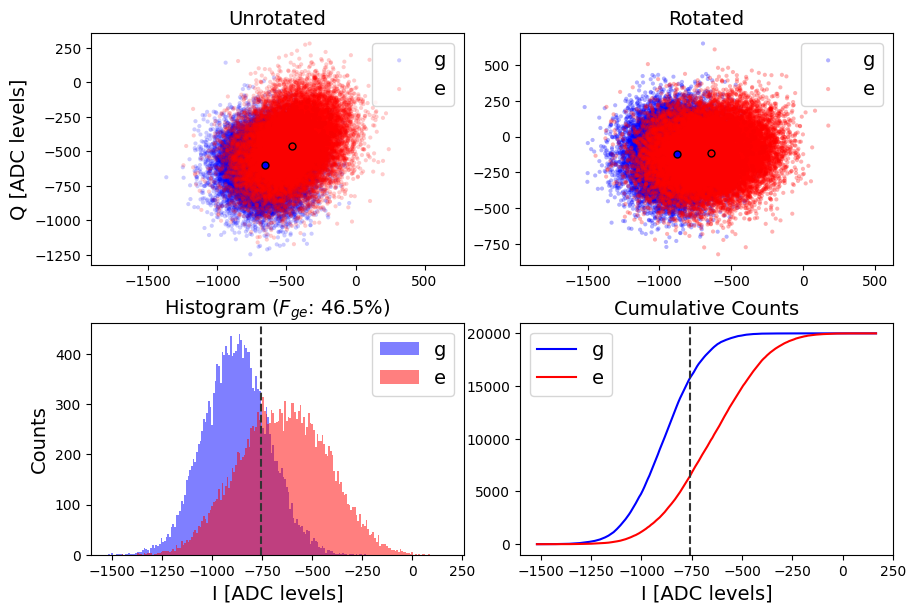

gf fidelity (%): 46.5361634040851
thresholds_f=[0, 0, 0, -757.0838505155868],
angles_f=[0, 0, 0, -34.37929590946284],
gf_avgs=[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), [-653.844522253865, -600.27864182262, -465.3276626118796, -460.3529818551668]],
counts_calib_f=[[15526.0, 4474.0], [15572.0, 4428.0], [6263.0, 13737.0]]


  0%|          | 0/31 [00:00<?, ?it/s]

In [36]:
rbprog = meas.SimultaneousRBEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb1Q_qubit{qubit_i}",
    config_file=config_path,
)

# gate_char = None
gate_char = 'X'

max_gates = 225
# max_gates = 100
# max_gates = 150
# max_gates = 40

expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    start=1, # rb depth start
    # start=200, # rb depth start
    step=step, # step rb depth
    # expts=1, # number steps
    expts=expts+1, # number steps
    reps=2000, # number averages per unique sequence
    reps_f=5000,
    # reps=200, # number averages per unique sequence
    # reps_f=500,
    loops=1,
    variations=15, # number different sequences per depth
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=[qubit_i], # the qubits to perform simultaneous RB on (if eg-gf, q should be qA != 1)
    ZZ_qubit=ZZ_qubit,
    test_qZZ=test_qZZ,
    # qubits=qubits,
    # qDrive=qubits[0],
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None
    measure_f=[qubit_i],

)

# print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [37]:
rbprog.save_data()

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00006_rb1Q_qubit3.h5


'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00006_rb1Q_qubit3.h5'

counts calib total shape (1, 3, 4)
counts raw shape (1, 31, 15, 4) (loops, depths, variations, 4)
[ 213.  1787.  1531.6  468.4]


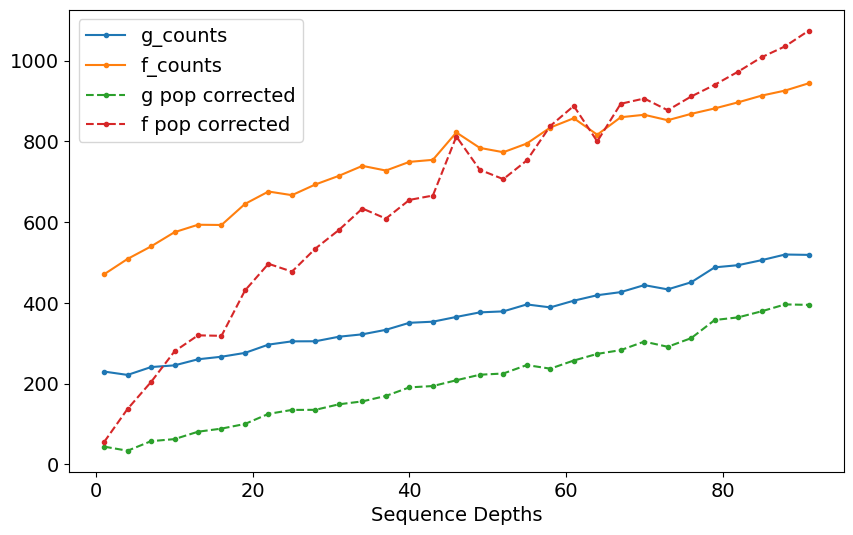

fit1 p1, a, offset [9.97785580e-01 9.89879811e-01 1.01866809e-16]
fit2 a0, b0, c0, p2 [2.43464567e-22 1.61032580e-13 9.50459544e-01 9.87525380e-01]
Running interleaved X gate RB on EF subspace
Depolarizing parameter p1 from fit: 0.9977855803667451 +/- 0.000916156777186585
Running interleaved X gate RB on EF subspace
Depolarizing parameter p2 from fit: 0.9875253797995719 +/- 0.0018098363377453284
Fidelity: 0.9926554800831586 +/- 1.6906690179134695e-06
Leakage L1: 0.00221441963325486
Seepage L2: 2.2557586136987885e-19
Depolarizing parameter p from e/subspace fit: 0.9896350266866283 +/- 0.0018075917045858431
Average RB gate error on e/subspace: 0.0051824866566858585 +/- 0.0009037958522929216
	Fidelity of e/subspace=1-error: 0.9948175133433141 +/- 0.0009037958522929216


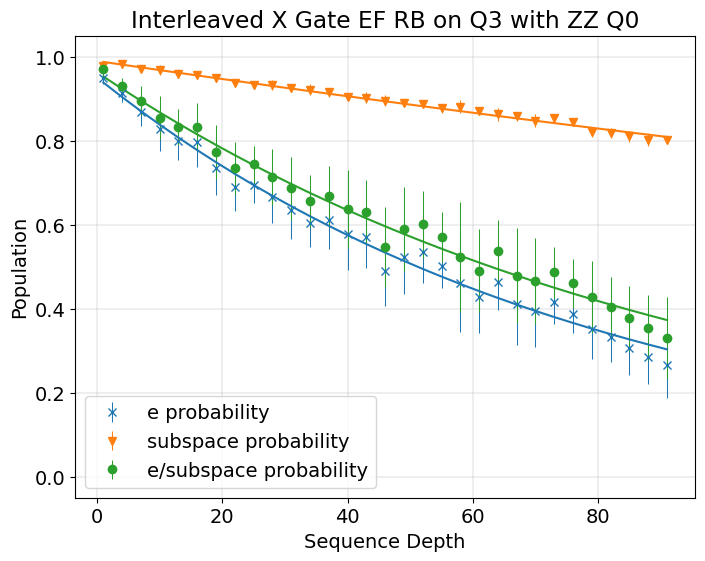

In [38]:
rbprog.analyze(fit=True, separate_correction=True)
rbprog.display(fit=True, show_all_vars=False)

# SWAP RB

## Calibrate swap phase

In [28]:
swap_qubit = 2

# ZZ_qubit = 0 # for tomography pulses
ZZ_qubit = None

test_pi_half = False

use_IQ_pulse = False
use_robust_pulses = True
full_mux_expt = True
resonator_reset = [0, 2, 3]

In [29]:
phaseprog = meas.EgGfPhaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGfPhaseCalib{swap_qubit}",
    config_file=config_path,
)

n_pulses = 8
# n_pulses = 2
if test_pi_half: n_pulses *= 2

qubit = 1

start = 0
span = 180
npts = 10

print('step size', span/npts)

phaseprog.cfg.expt = dict(
    start_phase=start,
    step_phase=span/npts,
    expts_phase=npts+1,
    reps=10000,
    singleshot_reps=10000,
    # singleshot_reps=100,
    swap_qubit=swap_qubit,
    test_pi_half=test_pi_half,
    n_pulses=n_pulses,
    qubit=qubit,
    use_IQ_pulse=use_IQ_pulse,
    use_robust_pulses=use_robust_pulses,
    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)
for q in range(4):
    if q != qubit:
        phaseprog.cfg.device.readout.gain[q] = 1e-4

# print(phaseprog.cfg)

import Pyro4.util
try:
    phaseprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

step size 18.0


  0%|          | 0/2 [00:00<?, ?it/s]

ge fidelity (%): 50.299999999999976 	 angle (deg): 0.0 	 threshold ge: 1172.0014727229668
thresholds=[0, 1172.0014727229668, 0, 0],
angles=[0, 0.0, 0, 0],
ge_avgs=[ 963.15142482    0.         1377.20431961    0.        ] ,
counts_calib=[[7610.0, 2390.0], [2583.0, 7417.0]]


  0%|          | 0/11 [00:00<?, ?it/s]

In [24]:
phaseprog.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00000_EgGfPhaseCalib3.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00000_EgGfPhaseCalib3.h5'

In [30]:
if swap_qubit == 2:
    target_X_counts = [1, 0]
elif swap_qubit == 3:
    target_X_counts = [0.78406, 0.21594]
else:
    assert False

phaseprog.analyze(target_X_counts=target_X_counts)
phaseprog.display()

target X pop 0.0
phase adjust for 1 pi swap: 180.0 deg


## Calibrate phase between X/2 and X

In [24]:
qubits = [2, 1]
qDrive = 2

# ZZ_qubit = 0 # for tomography pulses
ZZ_qubit = None

test_pi_half = False

use_IQ_pulse = False
use_robust_pulses = True
full_mux_expt = True
resonator_reset = [0, 2, 3]

In [28]:
phaseprog = meas.EgGfX_Xhalf_PhaseCalib_Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGfX_Xhalf_PhaseCalib{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

n_cycles = 16

qubit = 1

start = 0
span = 180
npts = 15

print('step size', span/npts)

phaseprog.cfg.expt = dict(
    start=start,
    step=span/npts,
    expts=npts+1,
    reps=5000,
    loops=1,
    singleshot_reps=10000,
    # singleshot_reps=100,
    n_cycles=n_cycles,

    post_process=None,
    measure_f=False,
    qDrive=qDrive,
    qubits=qubits,

    use_IQ_pulse=use_IQ_pulse,
    use_robust_pulses=use_robust_pulses,
    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)
for q in range(4):
    if q not in qubits:
        phaseprog.cfg.device.readout.gain[q] = 1e-4

# print(phaseprog.cfg)

import Pyro4.util
try:
    phaseprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

step size 12.0


  0%|          | 0/16 [00:00<?, ?it/s]

In [29]:
phaseprog.display(fit=False)

## Run RB

### Test RB

In [15]:
# qubits = [2, 1]
# qDrive = 2

qubits = [2, 1]
qDrive = 2

full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None

In [146]:
# step_sb = 15
# end_sb = 100

# step_leak = 15
# end_leak = 300
# sb = np.arange(1, end_sb+step_sb, step_sb)
# lk = np.arange(sb[-1]+step_leak, end_leak+step_leak, step_leak)
# depths = np.concatenate((sb, lk))
# print('depths', len(depths))
# print(depths)


depths = [300]

In [151]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'


# # expts = 30
# # expts = 19
# expts = 10

# # if gate_char is None: max_gates = 500
# if gate_char is None: max_gates = 100
# else: max_gates = 300

# step = max_gates // expts
# step = 10
# print('step', step)

rbprog.cfg.expt = dict(
    depths=depths,

    # variations=20,
    variations=1,

    # reps=3000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    # reps_f=3000,
    reps=250000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    # reps_f=1000000,
    # reps=100,
    loops=1,
    # loops=1,
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=10000, # reps per state for singleshot calibration
    # singleshot_reps_f=15000, # reps per state for singleshot calibration
    # singleshot_reps=800, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f_only=True,
    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,

    validate_variations=False,

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.acquire(progress=True, debug=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-389.975, 5795.761666663333, 502.368233333334, -228.9], 'gain': [0.5, 0.6, 0.4, 0.3], 'readout_length': [5, 20, 10, 8], 'frequency_ef': [-391.91408405, 5795.76166666, 500.44439227, -230.30732892], 'gain_ef': [0.05, 0.6, 0.4, 0.25], 'readout_length_ef': [1, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.144451095202, 4105.783958808882, 4111.0028964412795, 4110.5966963096635, 3442.9795552267146, 3448.3315918098933, 3447.233490336077, 3447.0285717924894, 4762.767009306428, 4761.793655204115, 4762.902435440665, 4762.367822139689, 4380.662337410765, 4379.890920412824, 4380.6668186549305, 4381.242475074487], 'f_ef': [3885.3117884920853, 0.0, 0.0, 0.0, 0.0, 3347.8480888529375, 0.0, 0.0, 4571.9056482340775, 4571.070566218902, 4572.9717022650675, 0.0, 4211.573193413508, 4207.17517228526, 0.0, 4209.900559061916], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q_half': [

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 76.67999999999996
Qubit (2) gf
gf fidelity (%): 58.2771777177718
thresholds_f=[0, 64.3054955925261, -71.98741514160916, 0],
angles_f=[0, 11.354629018661239, -88.60299336175007, 0],
gf_avgs=[array([0., 0., 0., 0.]), array([ 40.56865684,  -2.89864943,  88.70829486, -12.56563911]), array([ -9.83762904, -93.07811172,  -8.82907702, -51.7223151 ]), array([0., 0., 0., 0.])],
counts_calib_f=[[8061, 1354, 494, 91], [2471, 6462, 267, 800], [1358, 405, 6629, 1608], [506, 1211, 2270, 6013]]


  0%|          | 0/1 [00:00<?, ?it/s]

In [152]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00011_rb_EgGf_qubit31.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=False, show_all_vars=False)

[300.]
counts calib total shape (1, 4, 4)
[[[8061 1354  494   91]
  [2471 6462  267  800]
  [1358  405 6629 1608]
  [ 506 1211 2270 6013]]]
counts raw shape (1, 1, 1, 4)


  0%|          | 0/1 [00:00<?, ?it/s]

minimization error 0.004799735277488412
counts raw [0.76536  0.176788 0.046956 0.010896]
counts_corrected [[ 9.23830645e-01  7.61693547e-02 -3.05942805e-17 -1.64251139e-16]]
depth: 0
count [0.76536  0.176788 0.046956 0.010896]
poplns_2q_loops shape (1, 1, 1, 4)
poplns_2q shape (1, 1, 4)
shape sum prob_eg + prob_gf (1, 1)
shape average sum over each depth (1,) should equal (1,)
Attempted to init fitparam 1 to 0.0, which is out of bounds 0 to 0.6855241924308199. Instead init to 0.34276209621540993
Attempted to init fitparam 2 to 0.07616935471453554, which is out of bounds 0 to 0.07616935471453554. Instead init to 0.03808467735726777
fit1 p1, a, offset [0.9        0.34162587 0.07609497]
fit2 a0, b0, c0, p2 [7.43114951e-05 4.38888139e-01 5.00000000e-01 4.50000002e-01]
Attempted to init fitparam 1 to 0.0, which is out of bounds 0 to -3.6149515180871565e-15. Instead init to -1.8074757590435782e-15
Attempted to init fitparam 2 to -4.0166127978746186e-16, which is out of bounds 0 to -4.0166127

 s:\Seb\experiements\qram_tprocv1_expts\experiments\fitting.py: 877OptimizeWarning: Covariance of the parameters could not be estimated
 s:\Seb\experiements\qram_tprocv1_expts\experiments\fitting.py: 939

In [18]:
rbprog.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00000_rb_EgGf_qubit31.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00000_rb_EgGf_qubit31.h5'

### RUN RB

In [84]:
# qubits = [2, 1]
# qDrive = 2

qubits = [3, 1]
qDrive = 3

full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None

#### RB

In [110]:
step_sb = 10
end_sb = 200

step_leak = 25
end_leak = 500
sb = np.arange(1, end_sb+step_sb, step_sb)
lk = np.arange(sb[-1]+step_leak, end_leak+step_leak, step_leak)
depths = np.concatenate((sb, lk))


depths = [1, 600, 800]

# depths = np.arange(1, 200, 40)

print('depths', len(depths))
print(depths)

plt.figure()
plt.plot(depths, np.ones_like(depths), 'o')
plt.show()

depths 3
[1, 600, 800]


In [126]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'

rbprog.cfg.expt = dict(
    depths=depths,
    variations=1,
    # variations=1,
    reps=5000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=1,
    # variations=1,
    # reps=100,
    # loops=1,
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=5000, # reps per state for singleshot calibration
    # singleshot_reps=8000, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f_only=False,
    measure_f=[qDrive],
    add_phase=False,

    # cool_qubits=[0, 1],

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,

    validate_variations=False,

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-389.975, 5795.761666663333, 502.368233333334, -228.9], 'gain': [0.5, 0.6, 0.4, 0.3], 'readout_length': [5, 20, 10, 8], 'frequency_ef': [-391.91408405, 5795.76166666, 500.44439227, -230.30732892], 'gain_ef': [0.05, 0.6, 0.4, 0.25], 'readout_length_ef': [1, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.144451095202, 4105.783958808882, 4111.0028964412795, 4110.5966963096635, 3442.9795552267146, 3448.3315918098933, 3447.233490336077, 3447.0285717924894, 4762.767009306428, 4761.793655204115, 4762.902435440665, 4762.367822139689, 4380.662337410765, 4379.890920412824, 4380.6668186549305, 4381.242475074487], 'f_ef': [3885.3117884920853, 0.0, 0.0, 0.0, 0.0, 3347.8480888529375, 0.0, 0.0, 4571.9056482340775, 4571.070566218902, 4572.9717022650675, 0.0, 4211.573193413508, 4207.17517228526, 0.0, 4209.900559061916], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q_half': [

  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 60.7565033006601 	 angle (deg): 15.335839879305713 	 threshold ge: 73.42662921428807
Qubit (3) ge
ge fidelity (%): 68.85761952390477 	 angle (deg): 109.62537125496544 	 threshold ge: 55.38172107199129
thresholds=[0, 73.42662921428807, 0, 55.38172107199129],
angles=[0, 15.335839879305713, 0, 109.62537125496544],
ge_avgs=[array([0., 0., 0., 0.]), array([ 54.04927188,  -3.86186927,  89.94197526, -13.70513796]), array([0., 0., 0., 0.]), array([ 49.26382116, -45.07295468,  30.59141131, -97.43778641])],
counts_calib=[[3592, 501, 778, 129], [767, 3340, 165, 728], [917, 144, 3469, 470], [235, 776, 734, 3255], [577, 3404, 73, 946], [157, 924, 505, 3414]]


  0%|          | 0/3 [00:00<?, ?it/s]

plotting shots
plotting shots
plotting shots


  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 76.45896779355877
Qubit (3) gf
gf fidelity (%): 39.660000000000004
thresholds_f=[0, 64.19730097165007, 0, -80.48234344464721],
angles_f=[0, 14.356675178260847, 0, 155.6052602975337],
gf_avgs=[array([0., 0., 0., 0.]), array([ 41.0817916 ,  -2.6610276 ,  89.65773438, -15.09406478]), array([0., 0., 0., 0.]), array([98.48699048, 14.42102775, 75.57438112,  4.02994353])],
counts_calib_f=[[3563, 1152, 223, 62], [3441, 1189, 277, 93], [691, 207, 3142, 960], [669, 249, 3082, 1000], [1703, 3006, 106, 185], [441, 545, 1815, 2199]]


  0%|          | 0/3 [00:00<?, ?it/s]

plotting shots
plotting shots
plotting shots


In [75]:
rbprog.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00018_rb_EgGf_qubit21.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00018_rb_EgGf_qubit21.h5'

In [108]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00011_rb_EgGf_qubit31.h5')
# rbprog.data = temp_daa
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True, show_all_vars=False)

[  1. 400. 600.]
counts calib total shape (1, 6, 8)
[[[4004  573  342   81 3567 1171  201   61]
  [ 836 3548   83  533 3440 1155  314   91]
  [ 723  124 3668  485  619  266 2933 1182]
  [ 142  701  577 3580  627  220 3086 1067]
  [ 495 4067   33  405 1808 2864  133  195]
  [ 131  853  503 3513  416  588 1646 2350]]]
counts raw shape (1, 3, 1, 8)


  0%|          | 0/3 [00:00<?, ?it/s]

minimization error 0.03448332218409956
counts raw [0.1246 0.039  0.7198 0.1166 0.1206 0.0446 0.6392 0.1956]
counts_corrected [[-1.08326175e-17  2.99494035e-17  9.65669587e-01  3.43304129e-02
  -1.75947093e-17  4.05512769e-18]]
depth: 0
count [0.1246 0.039  0.7198 0.1166 0.1206 0.0446 0.6392 0.1956]
minimization error 0.009588013290484759
counts raw [0.4616 0.314  0.1354 0.089  0.5362 0.2928 0.1172 0.0538]
counts_corrected [[0.51559322 0.08275104 0.11611653 0.02582517 0.23704796 0.02266608]]
depth: 1
count [0.4616 0.314  0.1354 0.089  0.5362 0.2928 0.1172 0.0538]
minimization error 0.004680475552006145
counts raw [0.4466 0.3458 0.108  0.0996 0.5714 0.2632 0.1156 0.0498]
counts_corrected [[0.47914288 0.22417668 0.08219798 0.04422194 0.15236683 0.01789369]]
depth: 2
count [0.4466 0.3458 0.108  0.0996 0.5714 0.2632 0.1156 0.0498]
poplns_2q_loops shape (1, 3, 1, 6)
poplns_2q shape (3, 1, 6)
shape sum prob_eg + prob_gf (3, 1)
shape average sum over each depth (3,) should equal (3,)
fit1 p1, 

In [ ]:
# p_irb = 0.9590834452029213 
# p_irb_err = 0.0002387037509980582
# p_rb = 0.9833366468001751 
# p_rb_err = 0.00011879294449350527

p_irb = 0.9378643954169977
p_irb_err = 0.02184963356373672
p_rb = 0.9736931040310971
p_rb_err = 0.01541381511169818 
print(100*meas.fitting.rb_error(p_rb, 2),'% average error')
gate_fid, gate_fid_err = meas.fitting.rb_gate_fidelity(p_rb=p_rb, p_irb=p_irb, d=2, p_rb_err=p_rb_err, p_irb_err=p_irb_err)
print(100*gate_fid, '+/-', 100*gate_fid_err, '% gate fidelity')

#### IRB

In [13]:
step_sb = 5
end_sb = 100

step_leak = 20
end_leak = 300
sb = np.arange(1, end_sb+step_sb, step_sb)
lk = np.arange(sb[-1]+step_leak, end_leak+step_leak, step_leak)
depths = np.concatenate((sb, lk))



depths = np.arange(1, 100, 10)


print('depths', len(depths))
print(depths)

plt.figure()
plt.plot(depths, np.ones_like(depths), 'o')
plt.show()

# depths = [30]

depths 10
[ 1 11 21 31 41 51 61 71 81 91]


In [95]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# gate_char = None
gate_char = 'X'

rbprog.cfg.expt = dict(
    depths=depths,
    variations=20,
    # variations=1,
    reps=5000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=1,
    # variations=1,
    # reps=100,
    # loops=1,
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=5000, # reps per state for singleshot calibration
    # singleshot_reps=8000, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f_only=True,
    measure_f=[qDrive],
    add_phase=False,

    # cool_qubits=[0, 1],

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,

    validate_variations=False,

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

import Pyro4.util
try:
    rbprog.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-389.975, 5795.761666663333, 502.368233333334, -228.9], 'gain': [0.5, 0.6, 0.4, 0.3], 'readout_length': [5, 20, 10, 8], 'frequency_ef': [-391.91408405, 5795.76166666, 500.44439227, -230.30732892], 'gain_ef': [0.05, 0.6, 0.4, 0.25], 'readout_length_ef': [1, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.144451095202, 4105.783958808882, 4111.0028964412795, 4110.5966963096635, 3442.9795552267146, 3448.3315918098933, 3447.233490336077, 3447.0285717924894, 4762.767009306428, 4761.793655204115, 4762.902435440665, 4762.367822139689, 4380.662337410765, 4379.890920412824, 4380.6668186549305, 4381.242475074487], 'f_ef': [3885.3117884920853, 0.0, 0.0, 0.0, 0.0, 3347.8480888529375, 0.0, 0.0, 4571.9056482340775, 4571.070566218902, 4572.9717022650675, 0.0, 4211.573193413508, 4207.17517228526, 0.0, 4209.900559061916], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q_half': [

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 76.02
Qubit (3) gf
gf fidelity (%): 32.300000000000004
thresholds_f=[0, 62.417455566768425, 0, -82.09522303291047],
angles_f=[0, 12.350680980344526, 0, 43.13532338185153],
gf_avgs=[array([0., 0., 0., 0.]), array([ 40.38685957,  -1.89920801,  88.71494925, -12.48122513]), array([0., 0., 0., 0.]), array([-49.86435842,  84.30145606, -34.59277469,  69.99289081])],
counts_calib_f=[[3269, 1402, 232, 97], [1716, 2866, 177, 241], [614, 258, 2892, 1236], [403, 499, 1763, 2335]]


  0%|          | 0/3 [00:00<?, ?it/s]

plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots


 s:\Seb\experiements\qram_tprocv1_expts\experiments\two_qubit\randbench.py: 2261

plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots
plotting shots


KeyboardInterrupt: 

In [215]:
rbprog.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00004_rb_EgGf_qubit31.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00004_rb_EgGf_qubit31.h5'

In [79]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00011_rb_EgGf_qubit31.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True)

[  0.  10.  20.  40.  50.  75. 100. 150. 200.]
counts calib total shape (1, 4, 4)
[[[4197  528  246   29]
  [1341 3140  149  370]
  [ 661  158 3600  581]
  [ 276  567 1263 2894]]]
counts raw shape (1, 9, 20, 4)


  0%|          | 0/9 [00:00<?, ?it/s]

minimization error 0.009140523385900105
counts raw [0.1282 0.0276 0.7068 0.1374]
counts_corrected [[ 4.67982780e-17 -1.28694097e-16  9.64146810e-01  3.58531902e-02]]
minimization error 0.037158040852552
counts raw [0.127  0.022  0.7514 0.0996]
counts_corrected [[-4.14274183e-16 -6.10532333e-16  1.00000000e+00 -3.42830802e-16]]
minimization error 0.01137717012266096
counts raw [0.1284 0.0258 0.729  0.1168]
counts_corrected [[-6.90144383e-16 -3.96325514e-16  1.00000000e+00 -1.02105392e-15]]
minimization error 0.028485785929126203
counts raw [0.1404 0.0182 0.7392 0.1022]
counts_corrected [[-1.77956965e-17  6.05980387e-17  1.00000000e+00 -1.84274962e-17]]
minimization error 0.00881904558217693
counts raw [0.1354 0.0266 0.706  0.132 ]
counts_corrected [[ 3.69182670e-03 -4.03373690e-16  9.68432374e-01  2.78757992e-02]]
minimization error 0.007696714589199552
counts raw [0.1374 0.0294 0.694  0.1392]
counts_corrected [[ 8.94243080e-03 -1.55637004e-16  9.45453303e-01  4.56042663e-02]]
minimizat